In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import timm


C:\Users\dmpoo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# data_dir = r'C:\Users\dmpoo\OneDrive\Desktop\Faces-HQ\Final'  # Replace with your path
data_dir = r'C:\Users\dmpoo\OneDrive\Desktop\Faces-HQ\real-vs-fake'
data_dir = r'C:\Users\dmpoo\OneDrive\Desktop\Faces-HQ\Final_old\Final'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4)
               for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes


In [3]:
# model = timm.create_model('levit_128s.fb_dist_in1k', pretrained=True)
model = timm.create_model('levit_128s', pretrained=False)

num_classes = 2  # Number of classes in your dataset
model.head.linear = nn.Linear(in_features=model.head.linear.in_features, out_features=2)
model.head_dist.linear = nn.Linear(in_features=model.head_dist.linear.in_features, out_features=2)

# Move the model to the appropriate device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


model

C:\Users\dmpoo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


LevitDistilled(
  (stem): Stem16(
    (conv1): ConvNorm(
      (linear): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (act1): Hardswish()
    (conv2): ConvNorm(
      (linear): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (act2): Hardswish()
    (conv3): ConvNorm(
      (linear): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (act3): Hardswish()
    (conv4): ConvNorm(
      (linear): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (stages): Sequential(
    (

In [4]:
criterion = nn.CrossEntropyLoss()

# All parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


In [5]:
import copy
import torch
from tqdm import tqdm

num_epochs = 10
best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0

# To store metrics for plotting
metrics = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')

    # Training Phase
    model.train()  # Set model to training mode
    running_loss = 0.0
    running_corrects = 0

    # Iterate over data.
    for inputs, labels in tqdm(dataloaders['train'], desc='Train', leave=False):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # Backward and optimize only if in training phase
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / dataset_sizes['train']
    epoch_acc = running_corrects.double() / dataset_sizes['train']

    metrics['train_loss'].append(epoch_loss)
    metrics['train_acc'].append(epoch_acc.item())

    print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    # Validation Phase
    model.eval()  # Set model to evaluate mode
    running_loss = 0.0
    running_corrects = 0

    # Disabling gradient calculation
    with torch.no_grad():
        for inputs, labels in tqdm(dataloaders['val'], desc='Val', leave=False):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            # print(outputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes['val']
        epoch_acc = running_corrects.double() / dataset_sizes['val']

        metrics['val_loss'].append(epoch_loss)
        metrics['val_acc'].append(epoch_acc.item())

        print(f'Val Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # Deep copy the model if it has the best accuracy so far
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())
    # Save the model at the end of each epoch
    torch.save(model.state_dict(), f'model_timm_scratch_LeViT_epoch_{epoch+1}.pth')


# Load and save the best model weights
model.load_state_dict(best_model_wts)
torch.save(best_model_wts, 'best_model_timm_scratch_LeViT.pth')


Epoch 1/10


Train Loss: 0.7399 Acc: 0.5306


Val Loss: 0.8003 Acc: 0.5444
Epoch 2/10


Train Loss: 0.7008 Acc: 0.5862


Val Loss: 0.5832 Acc: 0.6901
Epoch 3/10


Train Loss: 0.5879 Acc: 0.7007


Val Loss: 0.4617 Acc: 0.7836
Epoch 4/10


Train Loss: 0.5147 Acc: 0.7572


Val Loss: 0.3527 Acc: 0.8483
Epoch 5/10


Train Loss: 0.4588 Acc: 0.7957


Val Loss: 0.3254 Acc: 0.8613
Epoch 6/10


Train Loss: 0.4125 Acc: 0.8230


Val Loss: 0.2700 Acc: 0.8873
Epoch 7/10


Train Loss: 0.3722 Acc: 0.8425


Val Loss: 0.2691 Acc: 0.8968
Epoch 8/10


Train Loss: 0.3356 Acc: 0.8597


Val Loss: 0.2081 Acc: 0.9173
Epoch 9/10


Train Loss: 0.3023 Acc: 0.8752


Val Loss: 0.1805 Acc: 0.9267
Epoch 10/10


Train Loss: 0.2774 Acc: 0.8833


Val Loss: 0.1634 Acc: 0.9360


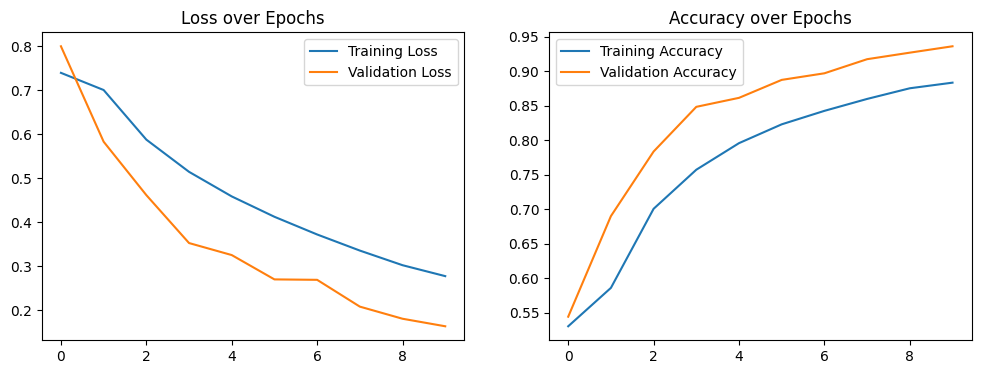

In [6]:

# Plot metrics
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(metrics['train_loss'], label='Training Loss')
plt.plot(metrics['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(metrics['train_acc'], label='Training Accuracy')
plt.plot(metrics['val_acc'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.show()


In [7]:
from torchvision import transforms

# Redefining the test_transforms with the necessary import
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Reload the test dataset and dataloader with the correct transforms
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), test_transforms)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=True, num_workers=4)

# Re-evaluate the model on the test dataset
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = correct / total

accuracy, all_preds, all_labels



(0.9344771100956979,
 [0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  0,
  0,
  1,
  0,
  1,
  0,
  1,
  0,
  1,
  0,
  1,
  0,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  0,
  1,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  1,
  0,
  0,
  1,
  0,
  1,
  1,
  1,
  0,
  0,
  1,
  1,
  0,
  1,
  0,
  1,
  0,
  0,
  0,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  1,
  0,
  1,
  0,
  0,
  1,
  0,
  1,
  0,
  1,
  0,
  1,
  1,
  0,
  0,
  1,
  0,
  0,
  1,
  0,
  1,
  1,
  0,
  1,
  1,
  0,
  0,
  1,
  1,
  0,
  1,
  0,
  1,
  1,
  1,
  0,
  1,
  1,
  0,
  0,
  0,
  1,
  0,
  1,
  1,
  1,
  1,
  0,
  0,
  1,
  1,
  0,
  1,
  0,
  1,
  0,
  0,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  0,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  1,
  1,
  1,
  1,
  0,
  0,
  1,
  0,
  0,
  0,
  1,
  0,
  1,
  0,
  1,

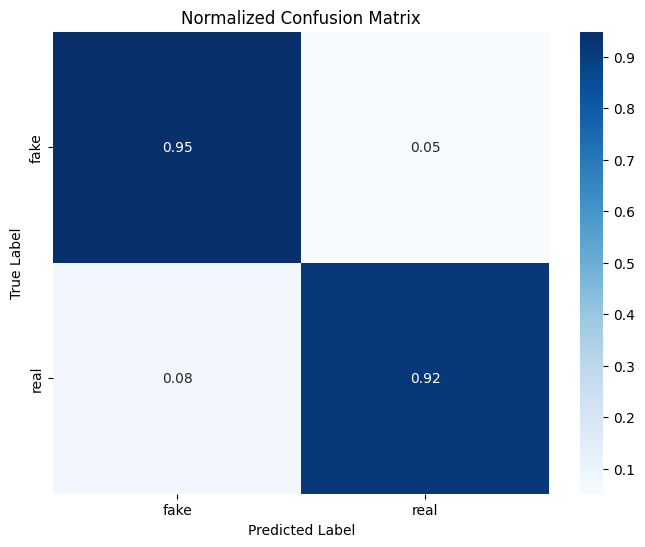

In [9]:
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Adjusted for the environment
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load test data
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), test_transforms)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=4)
class_names = test_dataset.classes

# Load the best model
model_path = r'C:\Users\dmpoo\OneDrive\Desktop\Faces-HQ\best_model_timm_scratch_LeViT.pth'  # Adjusted for the environment
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

# Predictions and labels
y_pred = []
y_true = []

# No need to track gradients
with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Plotting heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_normalized, annot=True, fmt=".2f", cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Normalized Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

